# 1 加载

In [7]:
import sys
import os
sys.path.insert(0, os.path.abspath('/notebooks/pytorch_timeseries'))

import datetime
from enum import Enum
import json
import os
import random
import re
import signal
import threading
import time
import hashlib
from prettytable import PrettyTable
import sys
####
from typing import Dict, List, Type, Union
import numpy as np
import torch
from torchmetrics import MeanSquaredError, MetricCollection, MeanAbsoluteError, MeanAbsolutePercentageError
from tqdm import tqdm
import wandb
from torch_timeseries.data.scaler import *
from torch_timeseries.datasets import *
from torch_timeseries.experiments.experiment import Experiment

from torch_timeseries.datasets.dataset import TimeSeriesDataset
from torch_timeseries.datasets.splitter import SequenceRandomSplitter, SequenceSplitter
from torch_timeseries.datasets.dataloader import (
    ChunkSequenceTimefeatureDataLoader,
    DDPChunkSequenceTimefeatureDataLoader,
)
from torch_timeseries.datasets.wrapper import MultiStepTimeFeatureSet
from torch_timeseries.models.Informer import Informer
from torch.nn import MSELoss, L1Loss

from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler, Subset

from torch.nn import DataParallel
import torch.nn as nn
from dataclasses import asdict,dataclass

from torch_timeseries.nn.metric import R2, Corr, TrendAcc,RMSE, compute_corr, compute_r2
from torch_timeseries.metrics.masked_mape import MaskedMAPE
from torch_timeseries.utils.early_stopping import EarlyStopping
import json
import codecs


## 1.1 数据集加载

In [2]:
dataset : TimeSeriesDataset = ExchangeRate(root='/notebooks/pytorch_timeseries/data')
scaler = StandarScaler()



# dataloader = ChunkSequenceTimefeatureDataLoader(
#     dataset,
#     scaler,
#     window=windows,
#     horizon=horizon,
#     steps=pred_len,
#     scale_in_train=False,
#     shuffle_train=True,
#     freq="h",
#     batch_size=batch_size,
#     train_ratio=0.7,
#     val_ratio=0.2,
#     num_worker=num_worker,
# )
# train_loader, val_loader, test_loader = (
#     dataloader.train_loader,
#     dataloader.val_loader,
#     dataloader.test_loader,
# )

Using downloaded and verified file: /notebooks/pytorch_timeseries/data/exchange_rate/exchange_rate.csv


## 1.2 数据集绘制

In [9]:
dataset : TimeSeriesDataset = PEMS_BAY(root='/notebooks/pytorch_timeseries/data')
# dataset : TimeSeriesDataset = METR_LA(root='/notebooks/pytorch_timeseries/data')



# dataset.dates



In [11]:
dataset.df

sensor_id,400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,...,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
2017-01-01 00:00:00,71.4,67.8,70.5,67.4,68.8,66.6,66.8,68.0,66.8,69.0,...,68.8,67.9,68.8,68.0,69.2,68.9,70.4,68.8,71.1,68.0
2017-01-01 00:05:00,71.6,67.5,70.6,67.5,68.7,66.6,66.8,67.8,66.5,68.2,...,68.4,67.3,68.4,67.6,70.4,68.8,70.1,68.4,70.8,67.4
2017-01-01 00:10:00,71.6,67.6,70.2,67.4,68.7,66.1,66.8,67.8,66.2,67.8,...,68.4,67.4,68.4,67.5,70.2,68.3,69.8,68.4,70.5,67.9
2017-01-01 00:15:00,71.1,67.5,70.3,68.0,68.5,66.7,66.6,67.7,65.9,67.8,...,68.5,67.5,68.5,67.5,70.4,68.7,70.2,68.4,70.8,67.6
2017-01-01 00:20:00,71.7,67.8,70.2,68.1,68.4,66.9,66.1,67.7,66.1,67.8,...,68.5,67.7,68.5,67.4,69.6,69.1,70.0,68.4,71.0,67.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-30 23:35:00,70.9,66.3,68.4,61.0,61.8,66.9,66.0,67.4,65.4,69.3,...,64.6,66.8,64.7,61.1,68.4,61.4,70.5,68.2,71.6,66.2
2017-06-30 23:40:00,71.3,66.6,68.7,60.9,62.0,66.2,66.5,68.2,64.9,69.1,...,65.1,67.3,64.8,60.8,69.8,62.2,69.4,68.6,71.6,68.4
2017-06-30 23:45:00,71.4,66.9,68.1,61.1,62.0,66.7,65.8,68.2,64.2,69.1,...,64.9,66.5,64.6,61.3,69.5,63.8,70.6,68.4,71.6,66.6
2017-06-30 23:50:00,72.2,66.5,68.0,61.1,62.5,65.8,67.1,68.3,64.0,67.3,...,64.1,65.9,64.8,61.3,69.6,64.2,70.2,68.7,71.6,68.4


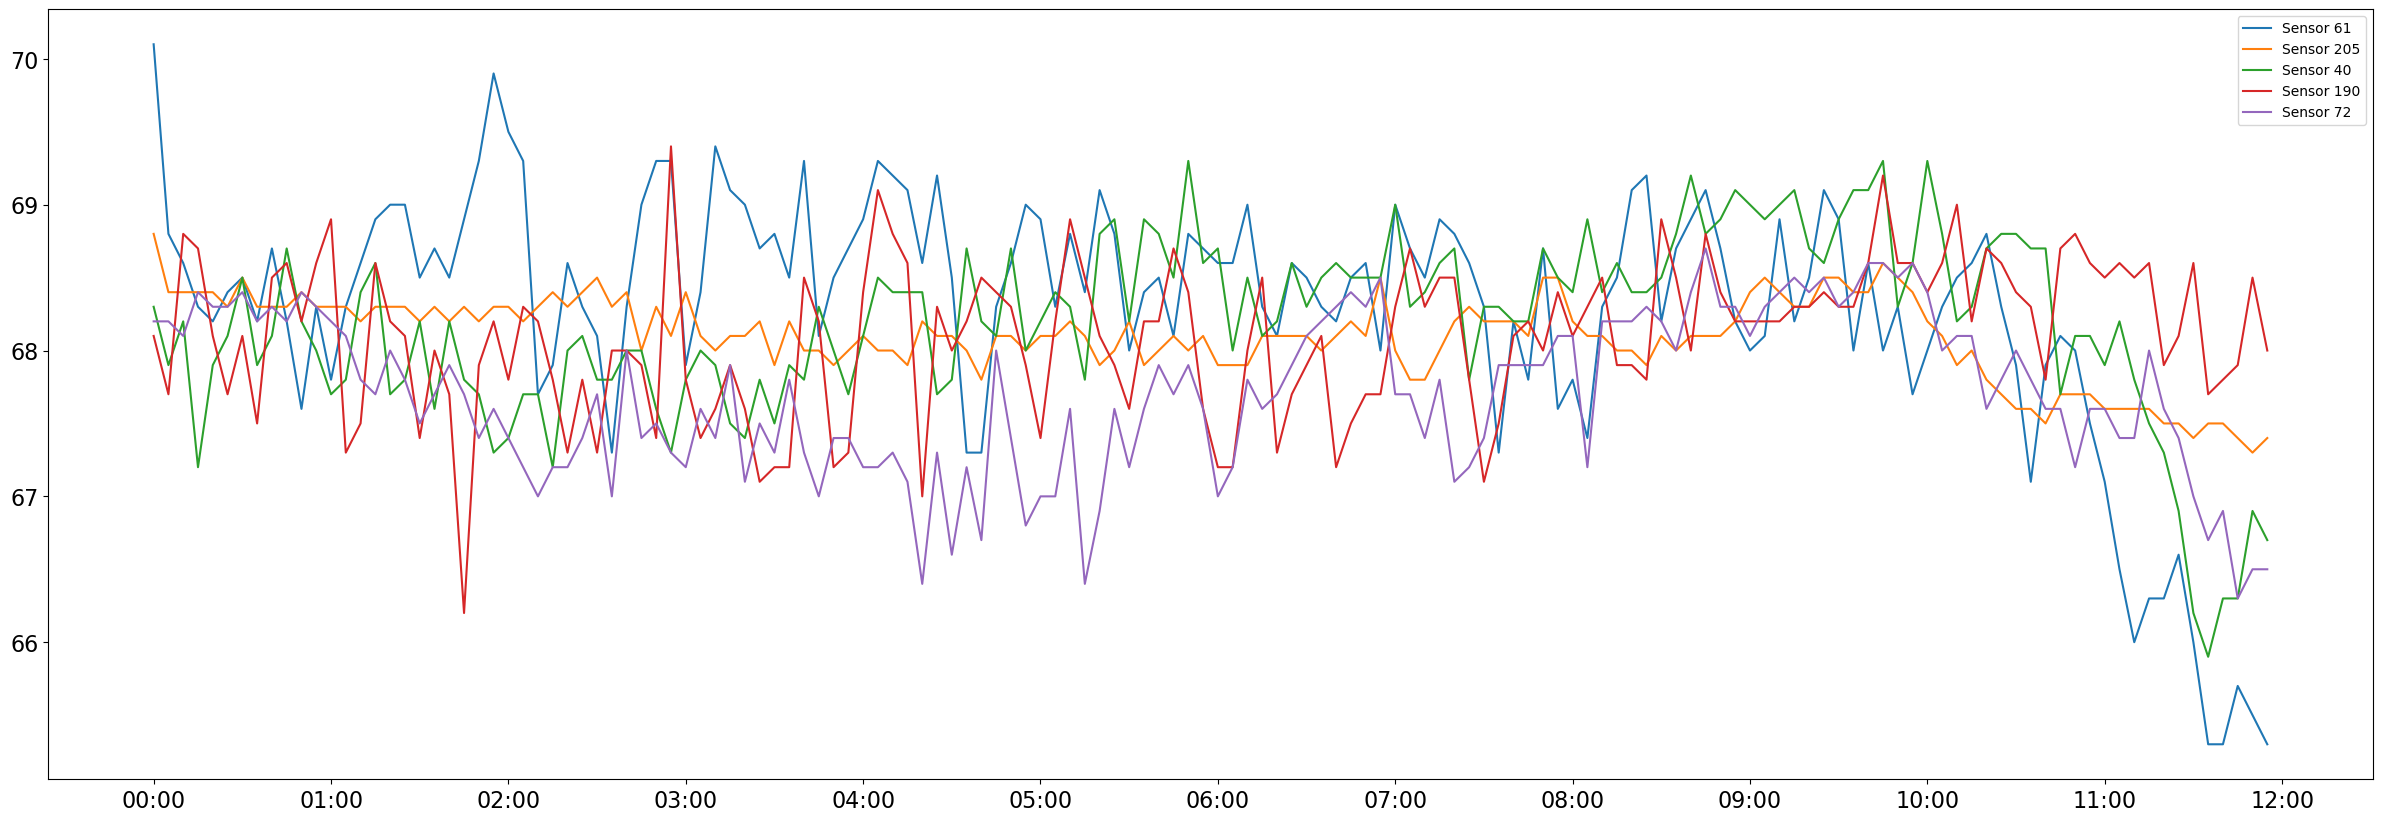

In [4]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # 导入日期处理模块


indexs = [61,205,40,190,72]
sub_df = dataset.df[0:144]
# .iloc[:, [61,205,40,190,72]]
plt.figure(figsize=(30, 10))
for i in indexs:
    plt.plot(sub_df.iloc[:, i], label=f'Sensor {i}')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 设置小时和分钟格式
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # 设置小时刻度间隔
# 设置刻度标签的字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# 设置图例的字体大小
plt.legend(['数据'], fontsize=16)

# plt.grid(True)

plt.legend()
plt.savefig('save.svg')

In [5]:
len(sub_df.columns)

12

In [10]:
dataset.df[0:200].iloc[:, -12:]

sensor_id,408911,409524,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
2017-01-01 00:00:00,68.6,67.2,68.8,67.9,68.8,68.0,69.2,68.9,70.4,68.8,71.1,68.0
2017-01-01 00:05:00,68.3,67.6,68.4,67.3,68.4,67.6,70.4,68.8,70.1,68.4,70.8,67.4
2017-01-01 00:10:00,68.4,67.4,68.4,67.4,68.4,67.5,70.2,68.3,69.8,68.4,70.5,67.9
2017-01-01 00:15:00,67.9,67.2,68.5,67.5,68.5,67.5,70.4,68.7,70.2,68.4,70.8,67.6
2017-01-01 00:20:00,67.7,67.8,68.5,67.7,68.5,67.4,69.6,69.1,70.0,68.4,71.0,67.9
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01 16:15:00,61.9,68.2,66.2,66.0,66.2,65.4,65.4,65.9,68.6,66.1,68.4,65.8
2017-01-01 16:20:00,61.7,68.4,66.2,66.5,66.2,65.3,64.7,66.2,68.6,66.1,68.8,65.5
2017-01-01 16:25:00,60.5,67.7,66.3,66.2,66.3,65.6,65.0,64.8,68.9,66.2,68.4,65.4
2017-01-01 16:30:00,60.6,68.0,66.2,66.2,66.2,65.4,64.5,64.6,68.5,66.1,68.3,65.5


## 1.3 Map绘制


### PEMS_BAY

In [4]:
import folium
import pandas as pd

# 创建一个地图对象
m = folium.Map(location=[37.329258,-122.012053], zoom_start=11)

# 读取CSV文件数据
data = pd.read_csv('/notebooks/pytorch_timeseries/data/PEMS-BAY/graph_sensor_locations_bay.csv', header=None)

# 修改列名
data.columns = ['ID', 'latitude', 'longitude']

# 遍历数据并添加标记
for index, row in data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color='red'),
        tooltip=f'ID: {row["ID"]}'  # 使用ID作为悬停文本
    ).add_to(m)

    # 添加永久显示的文本
    folium.map.Marker(
        [row['latitude'], row['longitude']],
        icon=folium.DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            # html=f'<div style="font-size: 12pt">{row["ID"]}</div>',
        )
    ).add_to(m)

# 保存地图到HTML文件
m.save('./map_with_markers.html')


In [20]:
str(row['sensor_id']) in dataset.df.columns

False

In [12]:
import folium
import pandas as pd

# 读取CSV文件数据
location_data = pd.read_csv('/notebooks/pytorch_timeseries/data/PEMS-BAY/graph_sensor_locations_bay.csv', header=None)
location_data.columns = ['sensor_id', 'latitude', 'longitude']

# 假设 dataset.df 是您提到的DataFrame，其列名为传感器ID
# 例如：dataset.df = pd.DataFrame(columns=['400001', '400017', ...])

# 创建一个地图对象
m = folium.Map(location=[37.329258,-122.012053], zoom_start=11)

# 遍历数据并添加标记
for index, row in location_data.iterrows():
    # 找到该传感器ID在 dataset.df 中的列顺序
    sensor_index = list(dataset.df.columns).index(int(row['sensor_id'])) if int(row['sensor_id']) in dataset.df.columns else None
    if sensor_index is not None:
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            icon=folium.Icon(color='red'),
            tooltip=f'Sensor ID: {row["sensor_id"]}, Index in dataset: {sensor_index}'
        ).add_to(m)
        folium.map.Marker(
            [row['latitude'], row['longitude']],
            icon=folium.DivIcon(
                icon_size=(150,36),
                icon_anchor=(0,0),
# html = f'<div style="font-size: 38pt; font-weight: 800">{sensor_index}</div>'
            )
        ).add_to(m)

# 保存地图到HTML文件
m.save('./map_with_sensor_indices.html')


### METR_LA

In [6]:
import folium
import pandas as pd

# 创建一个地图对象
m = folium.Map(location=[34.1, -118.25], zoom_start=11)  # 设置地图中心坐标和缩放级别

# 读取CSV文件数据
data = pd.read_csv('/notebooks/pytorch_timeseries/data/PEMS-BAY/graph_sensor_locations_bay.csv')

# 遍历数据并添加标记
for index, row in data.iterrows():
    # folium.Marker(
    #     location=[row['latitude'], row['longitude']],  # 获取经纬度信息
    #     icon=folium.Icon(color='red'),  # 设置标记为红色
    #     tooltip=f'Index: {index}'  # 使用索引作为悬停文本
    # ).add_to(m)
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color='red')
    ).add_to(m)
    
    # 添加永久显示的文本
    folium.map.Marker(
        [row['latitude'], row['longitude']],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 12pt">{index}</div>',
        )
    ).add_to(m)

# 保存地图到HTML文件
m.save('map_with_markers.html')


KeyError: 'latitude'

# 2 分析

## 2.1 协方差系数分析

In [1]:
def lagged_autocovariance_matrix(ts, max_lag):
    """
    计算多维时间序列的 k-lag 自协方差矩阵。
    
    :param ts: 多维时间序列，一个 numpy 数组，形状为 (时间点数, 变量数)。
    :param max_lag: 最大滞后量。
    :return: k-lag 自协方差矩阵，形状为 (max_lag+1, 变量数)。
    """
    n_obs, n_vars = ts.shape
    autocov_matrix = np.zeros((max_lag + 1, n_vars))

    for lag in range(max_lag + 1):
        for var in range(n_vars):
            if lag > 0 and n_obs - lag > 0:
                cov = np.cov(ts[:-lag, var], ts[lag:, var])[0, 1]
            else:
                cov = np.cov(ts[:, var], ts[:, var])[0, 1]
            autocov_matrix[lag, var] = cov

    return autocov_matrix



In [52]:
data = dataset.df.iloc[:, 1:].values
corr = lagged_autocovariance_matrix(dataset.df.iloc[:, 1:].values, 50)

In [26]:
import matplotlib.pyplot as plt

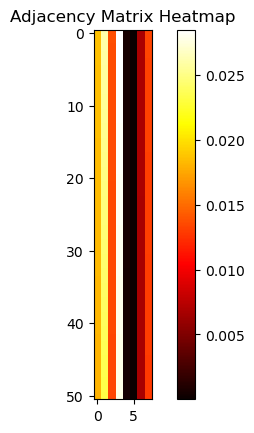

In [31]:
plt.imshow(corr, cmap='hot', interpolation='nearest')
# plt.axhline(y=8, color='blue', linestyle='-')
# plt.axvline(x=8, color='green', linestyle='-')

plt.colorbar()
plt.title('Adjacency Matrix Heatmap')
plt.show()

In [33]:
corr[:, 0]

array([0.01866514, 0.01864909, 0.01863785, 0.01862601, 0.01861483,
       0.0186035 , 0.01859178, 0.01858005, 0.0185691 , 0.0185571 ,
       0.01854558, 0.01853417, 0.01852247, 0.01851058, 0.01849903,
       0.01848761, 0.01847604, 0.01846518, 0.01845381, 0.01844291,
       0.01843182, 0.01842083, 0.01840988, 0.01839889, 0.01838852,
       0.01837835, 0.01836756, 0.01835612, 0.01834404, 0.01833144,
       0.01831779, 0.01830459, 0.01829136, 0.01827829, 0.01826447,
       0.0182505 , 0.01823718, 0.01822462, 0.01821197, 0.01819912,
       0.01818552, 0.01817155, 0.01815822, 0.01814456, 0.01813044,
       0.01811631, 0.01810205, 0.01808767, 0.01807303, 0.01805891,
       0.01804511])

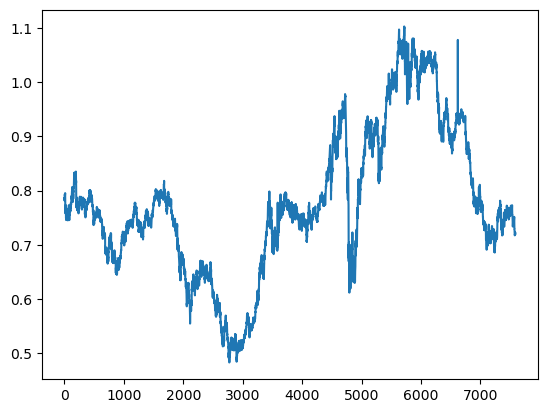

In [39]:
plt.plot(data[:,  0])

In [50]:
def rolling_window_subtraction(data, window_size):
    """
    使用指定窗口大小进行滚动，并对每个窗口内的数据减去窗口中最后一个时间步长的数据。

    :param data: 输入数据，形状为 (t, n)。
    :param window_size: 滚动窗口的大小。
    :return: 修改后的数据。
    """
    t, n = data.shape
    output = np.zeros((t - window_size + 1, n))

    for i in range(t - window_size + 1):
        window = data[i*window_size:i*window_size + window_size, :]  # 提取窗口
        last_step = window[-1: ,:]            # 窗口中最后一个时间步长的数据
        print(window, last_step)
        
        output[i] = window - last_step    # 窗口内所有数据减去最后一个时间步长的数据

    return output
rolling_window_subtraction(data, 10)

[[0.7855   1.611    0.861698 0.634196 0.211242 0.006838 0.525486 0.593   ]
 [0.7818   1.61     0.861104 0.633513 0.211242 0.006863 0.523972 0.594   ]
 [0.7867   1.6293   0.86103  0.648508 0.211242 0.006975 0.526316 0.5973  ]
 [0.786    1.637    0.862069 0.650618 0.211242 0.006953 0.523834 0.597   ]
 [0.7849   1.653    0.861995 0.656254 0.211242 0.00694  0.527426 0.5985  ]
 [0.7866   1.6537   0.86103  0.654879 0.211242 0.006887 0.526177 0.604   ]
 [0.7886   1.662    0.862887 0.661157 0.211242 0.006885 0.527565 0.607   ]
 [0.791    1.6568   0.864304 0.659631 0.211242 0.006878 0.527565 0.6084  ]
 [0.7939   1.6695   0.86423  0.66912  0.211242 0.006878 0.528123 0.6115  ]
 [0.7894   1.657    0.858369 0.659413 0.211242 0.006874 0.528123 0.609   ]] (8,)


ValueError: could not broadcast input array from shape (10,8) into shape (8,)

In [71]:
import numpy as np

def rolling_window_subtraction(data, window_size):
    """
    使用指定窗口大小进行滚动，并对每个窗口内的数据减去窗口中最后一个时间步长的数据。

    :param data: 输入数据，形状为 (t, n)。
    :param window_size: 滚动窗口的大小。
    :return: 修改后的数据。
    """
    t, n = data.shape
    output = []

    for i in range(0, int(int(t)/int(window_size))):
        window = data[i*window_size:i*window_size + window_size]  # 提取窗口
        last_step = window[-1]            # 窗口中最后一个时间步长的数据
        output.append( window - last_step[np.newaxis, :])  # 窗口内所有数据减去最后一个时间步长的数据

    return output

# 示例
# data = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])  # 示例数据
window_size = 168  # 窗口大小

# 计算滚动窗口减法
result = rolling_window_subtraction(data, window_size)
print(result)



[[[-4.7000e-02 -3.3550e-01 -1.7191e-02 ... -1.2500e-04 -4.1407e-02
   -3.7300e-02]
  [-5.0700e-02 -3.3650e-01 -1.7785e-02 ... -1.0000e-04 -4.2921e-02
   -3.6300e-02]
  [-4.5800e-02 -3.1720e-01 -1.7859e-02 ...  1.2000e-05 -4.0577e-02
   -3.3000e-02]
  ...
  [-1.4000e-03 -2.2000e-03  4.6400e-04 ... -4.0000e-05 -3.3540e-03
   -2.3000e-03]
  [-2.3000e-03  1.8000e-03 -3.3860e-03 ...  7.0000e-06  0.0000e+00
    1.0000e-03]
  [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
    0.0000e+00]]

 [[ 3.3800e-02  2.1850e-01  5.6780e-03 ... -2.4900e-04  2.2380e-03
    2.3300e-02]
  [ 3.3000e-02  1.8800e-01 -1.1270e-03 ... -2.3100e-04  2.2380e-03
    2.5400e-02]
  [ 3.1700e-02  1.7180e-01 -6.3470e-03 ... -2.1300e-04  2.5590e-03
    2.6600e-02]
  ...
  [-2.3000e-03  1.7500e-02  1.6580e-03 ...  7.0000e-05  1.9170e-03
   -2.3000e-03]
  [ 8.0000e-04  1.3500e-02  7.5300e-04 ...  4.9000e-05  1.5900e-04
   -1.2000e-03]
  [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
    0.

In [72]:
result.shape

(7421, 168, 8)